# Test calibrating the model parameters and initial conditions

Test whether we can use the BlackIT package to calibrate the model to i) synthetic data and ii) real data eventually

In [1]:
# Import required modules
import sys
import os
import logging
from datetime import datetime
import pandas as pd

# Add src directory to path
sys.path.append('../src')

from uk_abm.julia_model_wrapper import BeforeITModelWrapper
from uk_abm.data_loader import get_calibration_targets
from uk_abm.calibrate_beforeit import run_calibration, analyze_calibration_results

# Set up logging for notebook
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
# Step 1: Initialize the Julia model wrapper
wrapper = BeforeITModelWrapper(
    base_parameters="AUSTRIA2010Q1", 
    model_path="../dev/BeforeIT.jl",
    excluded_parameters=[
        "tau_SIW", "tau_SIF", "T_max", "beta_pi_EA", "tau_G", "alpha_G", 
        "r_star", "zeta_LTV", "beta_Y_EA", "tau_VAT", "alpha_Y_EA", 
        "beta_E", "rho", "S", "r_G", "alpha_E", "T", "L", "sigma_E", 
        "beta_I", "theta", "alpha_I", "sigma_pi_EA", "H_inact", "zeta", 
        "tau_EXPORT", "pi_star", "sigma_Y_EA", "T_prime", "beta_G", 
        "zeta_b", "psi_H", "sigma_G", "sigma_I", "G", "tau_FIRM", "J", 
        "xi_gamma", "tau_CF", "C",  # Input-output matrix (structural)
            "C_G",  # Government consumption matrix (data-driven)
            "C_E",  # Firm consumption matrix (data-driven)
            "c_E_g",  # Government expenditure coefficients (data-driven)
            "w_s",  # Sector wages (data-driven)
            "N_s",  # Sector employment (data-driven)
            "Y",  # Sector output (data-driven)
            "Y_I",  # Investment output (data-driven)
            "Y_EA",  # EA output (data-driven)
            "Y_EA_series",  # EA output series (data-driven)
            "pi",  # Sector-specific inflation (data-driven)
            "H_act",  # Active households (structural)
            "alpha_pi_EA",  # EA inflation coefficient (estimated elsewhere)
            "xi_pi",  # Inflation persistence (estimated elsewhere)
    ]
)

print(f"Configured to calibrate {len(wrapper.get_parameter_names())} parameters")
print(f"Base parameters: {wrapper.base_parameters}")


INFO:uk_abm.julia_model_wrapper:Setting up Julia environment...
INFO:uk_abm.julia_model_wrapper:Activating BeforeIT environment at: ../dev/BeforeIT.jl
  Activating project at `~/Documents/00. Bank of England/03. MPIL/uk_abm/dev/BeforeIT.jl`
INFO:uk_abm.julia_model_wrapper:Installing package dependencies...
INFO:uk_abm.julia_model_wrapper:Importing BeforeIT and required packages...
INFO:uk_abm.julia_model_wrapper:BeforeIT AUSTRIA2010Q1 parameters loaded successfully
INFO:uk_abm.julia_model_wrapper:Julia environment setup completed successfully
INFO:uk_abm.julia_model_wrapper:Found 5 calibratable parameters: ['tau_INC', 'theta_UB', 'psi', 'mu', 'theta_DIV']


Configured to calibrate 5 parameters
Base parameters: AUSTRIA2010Q1


In [3]:
# Step 2: Explore model parameters and variables
print("Step 2: Exploring model parameters and output variables...")

# Get parameter information
param_names = wrapper.get_parameter_names()
current_values = wrapper.get_current_parameter_values()
bounds = wrapper.get_parameter_bounds()

# Print Param information
print(f"Calibratable parameters ({len(param_names)}):")
for i, name in enumerate(param_names):
    current_val = current_values.get(name, 0.0)
    bound_range = bounds[i] if i < len(bounds) else [0, 1]
    print(f"  {name:15s}: {current_val:8.4f} (bounds: [{bound_range[0]:.3f}, {bound_range[1]:.3f}])")
    

# Get model output variables and print their names
variable_names = wrapper.get_variable_names()
print(f"\nModel output variables ({len(variable_names)}):")
for name in variable_names:
    print(f"  • {name}")


Step 2: Exploring model parameters and output variables...
Calibratable parameters (5):
  tau_INC        :   0.2134 (bounds: [0.100, 0.300])
  theta_UB       :   0.3586 (bounds: [0.400, 0.800])
  psi            :   0.9097 (bounds: [0.000, 1.000])
  mu             :   0.0267 (bounds: [0.000, 1.000])
  theta_DIV      :   0.7858 (bounds: [0.000, 1.000])

Model output variables (25):
  • nominal_gdp
  • real_gdp
  • nominal_gva
  • real_gva
  • nominal_household_consumption
  • real_household_consumption
  • nominal_government_consumption
  • real_government_consumption
  • nominal_capitalformation
  • real_capitalformation
  • nominal_fixed_capitalformation
  • real_fixed_capitalformation
  • nominal_fixed_capitalformation_dwellings
  • real_fixed_capitalformation_dwellings
  • nominal_exports
  • real_exports
  • nominal_imports
  • real_imports
  • operating_surplus
  • compensation_employees
  • wages
  • taxes_production
  • gdp_deflator_growth_ea
  • real_gdp_ea
  • euribor


In [4]:
# Step 3: Generate target data for calibration
print("Step 3: Generating model-aware target data...")

# Generate synthetic target data that matches model output variables
T = 8  # Short time series for quick testing
target_data, metadata = get_calibration_targets(
    variable_names=variable_names,
    data_source="synthetic", 
    T=T, 
    seed=42
)

print(f"Generated target data with shape: {target_data.shape}")
print(f"Data source: {metadata['source']}")

# Show a preview of the target data
df_preview = pd.DataFrame(target_data, columns=metadata['variables'][:target_data.shape[1]])
print("\nTarget data preview:")

df_preview


Step 3: Generating model-aware target data...
Generated target data with shape: (8, 25)
Data source: synthetic

Target data preview:


,nominal_gdp,real_gdp,nominal_gva,real_gva,nominal_household_consumption,real_household_consumption,nominal_government_consumption,real_government_consumption,nominal_capitalformation,real_capitalformation,...,real_exports,nominal_imports,real_imports,operating_surplus,compensation_employees,wages,taxes_production,gdp_deflator_growth_ea,real_gdp_ea,euribor
0,136500.000000,134000.000000,1000.000000,1000.000000,76500.000000,75000.000000,25500.000000,25000.000000,28600.000000,28000.000000,...,67000.000000,62200.000000,61000.000000,45000.000000,75000.000000,58000.000000,15000.000000,0.020000,9.500000e+06,0.015000
1,138270.014819,135224.690030,984.750822,999.742237,76667.909122,74600.620358,25635.305813,24848.695984,28449.372440,27609.593218,...,67659.856889,62804.755829,61702.679150,44645.110384,75402.597161,58239.963381,14871.545206,0.020018,9.563864e+06,0.014993
2,138978.615602,134877.812479,986.306700,1003.098848,77138.918310,75009.722868,25748.463204,24959.020586,28681.158251,28214.024098,...,69415.568287,65194.671193,62292.580893,44680.496495,75230.208925,58773.767765,15011.774632,0.019969,9.635483e+06,0.014972
3,140886.488464,135842.070520,983.495587,991.130920,77444.446160,74365.645052,25694.627286,24972.863707,29235.060085,28899.669873,...,69371.119237,65060.004815,61742.728981,45119.818164,76103.926175,58355.069464,15092.018523,0.020091,9.578546e+06,0.014954
4,143758.579268,135561.180948,995.405010,992.163443,79326.862485,74244.439795,25820.401346,24960.909978,30017.015831,28814.077780,...,69509.914160,65510.497329,62843.034115,45156.813377,75909.167526,58634.733416,15151.706505,0.020092,9.646143e+06,0.014943
5,143714.960534,135484.985264,992.126524,1000.046894,79670.574453,74891.439738,25995.767410,25088.949793,29938.803772,29240.349597,...,69443.860876,65752.549059,61977.483709,44672.607897,76014.573806,58905.518297,15214.117203,0.019993,9.667850e+06,0.014958
6,144031.678425,136313.568399,985.397634,993.554994,79441.164261,75633.725592,26398.692873,25228.065133,30109.201255,29303.739227,...,68019.019914,65254.882836,62660.080355,45263.647107,76583.197016,59299.787853,15143.760639,0.020034,9.712157e+06,0.014981
7,147078.609812,134706.800701,1010.077000,1004.887644,80601.527270,75943.886270,26619.814090,25323.036631,29864.027577,28960.008970,...,68647.761188,66812.724314,64191.764548,45122.529732,76283.793966,59043.849792,15213.135417,0.019966,9.810228e+06,0.014995


In [5]:
# Step 4 : Test single model simulation with new ModelResults API
print("Step 4: Testing single model simulation")

# Use middle-of-bounds parameters for testing
# bounds is now shape [2, n_params] where bounds[0,:] = lower, bounds[1,:] = upper
test_params = (bounds[0, :] + bounds[1, :]) / 2
print(f"Testing with {len(test_params)} middle-of-bounds parameters")

# Run a quick single simulation - now returns ModelResults object
result = wrapper.run_single_simulation(test_params, T=T, seed=42)

result.to_calibration_array().shape, target_data.shape


INFO:uk_abm.julia_model_wrapper:Running single simulation with T=8, seed=42


Step 4: Testing single model simulation
Testing with 5 middle-of-bounds parameters


INFO:uk_abm.julia_model_wrapper:Single simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_employees', 'euribor', 'gdp_deflator_growth_ea', 'nominal_capitalformation', 'nominal_exports', 'nominal_fixed_capitalformation', 'nominal_fixed_capitalformation_dwellings', 'nominal_gdp', 'nominal_government_consumption', 'nominal_gva', 'nominal_household_consumption', 'nominal_imports', 'operating_surplus', 'real_capitalformation', 'real_exports', 'real_fixed_capitalformation', 'real_fixed_capitalformation_dwellings', 'real_gdp', 'real_gdp_ea', 'real_government_consumption', 'real_gva', 'real_household_consumption', 'real_imports', 'taxes_production', 'wages']


((8, 25), (8, 25))

In [6]:
# # Step 4 : Test single model simulation with new ModelResults API
# print("Step 4: Testing single model simulation")

# # Use middle-of-bounds parameters for testing
# test_params = [(b[0] + b[1]) / 2 for b in bounds]
# print(f"Testing with {len(test_params)} middle-of-bounds parameters")

# # Run a quick single simulation - now returns ModelResults object
# result = wrapper.run_single_simulation(test_params, T=T, seed=42)

# print(f"\n📊 ModelResults Summary:")
# print(f"  • Total variables: {len(result.variables)}")
# print(f"  • Time series variables: {len(result.list_timeseries_variables())}")
# print(f"  • Panel data variables: {len(result.list_panel_variables())}")
# print(f"  • Time periods: {result.time_periods}")

# print(f"\n📈 Available 1D time series:")
# for var in result.list_timeseries_variables()[:5]:  # Show first 5
#     print(f"  • {var}")
# if len(result.list_timeseries_variables()) > 5:
#     print(f"  ... and {len(result.list_timeseries_variables()) - 5} more")

# print(f"\n📋 Available panel data:")
# for var in result.list_panel_variables()[:3]:  # Show first 3
#     data_shape = result.variables[var].original_shape
#     print(f"  • {var}: shape {data_shape}")
# if len(result.list_panel_variables()) > 3:
#     print(f"  ... and {len(result.list_panel_variables()) - 3} more")

# # Convert to calibration array (backward compatible format)
# calibration_array = result.to_calibration_array()
# print(f"\n🔄 Calibration array shape: {calibration_array.shape}")

# # Show how to access specific data types
# timeseries_data = result.get_scalar_timeseries()
# panel_data = result.get_panel_data()
# aggregated_panels = result.get_aggregated_panels(method="sum")

# print(f"\n✨ Flexible data access:")
# print(f"  • Direct time series: {len(timeseries_data)} variables")
# print(f"  • Raw panel data: {len(panel_data)} variables") 
# print(f"  • Aggregated panels: {len(aggregated_panels)} variables")

# # Create a DataFrame for visualization (using calibration array)
# var_names_for_df = result.list_timeseries_variables()
# if len(aggregated_panels) > 0:
#     var_names_for_df.extend([f"{k}_aggregated" for k in list(aggregated_panels.keys())[:3]])

# result_df = pd.DataFrame(calibration_array, columns=var_names_for_df[:calibration_array.shape[1]])
# print("\n📋 Simulation output preview:")
# result_df.head()


In [7]:
# # Advanced ModelResults API demonstration
# print("🔬 Advanced ModelResults API Demonstration")
# print("="*50)

# # Show detailed variable information
# variable_summary = result.get_variable_summary()
# print("\n📊 Detailed Variable Summary:")

# print("\n1️⃣ Time Series Variables (1D):")
# for var_name in result.list_timeseries_variables()[:3]:
#     info = variable_summary[var_name]
#     data_range = info['data_range']
#     print(f"  • {var_name}: range [{data_range[0]:.3f}, {data_range[1]:.3f}]")

# print("\n2️⃣ Panel Data Variables (2D):")
# for var_name in result.list_panel_variables()[:2]:
#     info = variable_summary[var_name]
#     shape = info['shape']
#     data_range = info['data_range'] 
#     print(f"  • {var_name}: shape {shape}, range [{data_range[0]:.3f}, {data_range[1]:.3f}]")

# # Demonstrate different aggregation methods for panel data
# if len(result.list_panel_variables()) > 0:
#     print("\n🔧 Panel Data Aggregation Methods:")
    
#     # Try different aggregation methods
#     aggregation_methods = ['sum', 'mean', 'max', 'min']
#     panel_var = result.list_panel_variables()[0]
    
#     print(f"\nUsing panel variable: {panel_var}")
#     for method in aggregation_methods:
#         try:
#             aggregated = result.get_aggregated_panels(method=method, variables=[panel_var])
#             if panel_var in aggregated:
#                 values = aggregated[panel_var]
#                 print(f"  • {method:4s}: [{values[0]:.3f}, {values[1]:.3f}, ..., {values[-1]:.3f}]")
#         except Exception as e:
#             print(f"  • {method:4s}: Error - {e}")

# # Show how to create custom calibration arrays with specific variables
# print("\n🎯 Custom Calibration Arrays:")

# # Example 1: Only GDP-related variables
# gdp_vars = [var for var in result.list_timeseries_variables() if 'gdp' in var.lower()]
# if gdp_vars:
#     gdp_array = result.to_calibration_array(variables=gdp_vars)
#     print(f"  • GDP-only array: {gdp_array.shape} for variables {gdp_vars}")

# # Example 2: Include aggregated panels with mean instead of sum
# mean_array = result.to_calibration_array(
#     include_aggregated_panels=True, 
#     panel_aggregation='mean'
# )
# print(f"  • Mean-aggregated panels: {mean_array.shape}")

# # Example 3: Only time series, no panel aggregation
# timeseries_only = result.to_calibration_array(include_aggregated_panels=False)
# print(f"  • Time series only: {timeseries_only.shape}")

# print("\n✅ ModelResults API provides flexible access to all simulation data!")
# print("   Perfect for different calibration needs and detailed economic analysis.")


In [8]:
# # Step 4: Test single model simulation
# print("🧪 Step 4: Testing single model simulation...")

# # Use middle-of-bounds parameters for testing
# test_params = [(b[0] + b[1]) / 2 for b in bounds]
# print(f"Testing with {len(test_params)} middle-of-bounds parameters")

# # Run a quick single simulation
# result = wrapper.run_single_simulation(test_params, T=T, seed=42)

# print(f"Output shape: {result.shape}")
# print(f"Variables x Time periods: {result.shape[1]} x {result.shape[0]}")

# # Show simulation results preview
# result_df = pd.DataFrame(result, columns=variable_names[:result.shape[1]])
# print("Simulation output preview:")
# result_df.head()


In [13]:
from black_it.samplers.random_forest import RandomForestSampler
from black_it.samplers.random_uniform import RandomUniformSampler
from uk_abm.calibrate_beforeit import setup_samplers

# Step 5: Run mini-calibration
print("Step 5: Running mini-calibration...")

# Create results folder
results_folder = f"../calibration_results/notebook_test_{datetime.now().strftime('%Y%m%d_%H%M')}"
os.makedirs(results_folder, exist_ok=True)

print(f"Results folder: {results_folder}")

samplers = [RandomUniformSampler(batch_size=4)]
samplers = setup_samplers(batch_size=4)

# Run very short calibration for demonstration
print("Starting calibration...")
best_params, best_losses, calibrator = run_calibration(
    model_wrapper=wrapper,
    target_data=target_data,
    results_folder=results_folder,
    max_iterations=3,    # Very short for demo
    ensemble_size=1,     # Small ensemble for speed  
    samplers=samplers,
    n_jobs=1,
)

print("✅ Calibration completed!")
print(f"🎯 Best loss achieved: {best_losses[0]:.6f}")
print(f"📊 Results saved in: {results_folder}")


INFO:uk_abm.calibrate_beforeit:Setting up samplers with batch size 4
INFO:uk_abm.calibrate_beforeit:Starting calibration process
INFO:uk_abm.calibrate_beforeit:Running calibration for 3 iterations
INFO:uk_abm.calibrate_beforeit:Parameter bounds: {'tau_INC': array([0.1  , 0.3  , 0.4  , 0.005, 0.2  ]), 'theta_UB': array([0.4 , 0.8 , 0.9 , 0.05, 0.8 ])}
INFO:uk_abm.julia_model_wrapper:Running simulation with T=8, ensemble_size=1, seed=1718225747
INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_employees', 'euribor', 'gdp_deflator_growth_ea', 'nominal_capitalformation', 'nominal_exports', 'nominal_fixed_capitalformation', 'nominal_fixed_capitalformation_dwellings', 'nominal_gdp', 'nominal_government_consumption', 'nominal_gva', 'nominal_household_consumption', 'nominal_imports', 'operating_surplus', 'real_capitalformation', 'real_exports', 'real_fixed_capitalformation', 're

Step 5: Running mini-calibration...
Results folder: ../calibration_results/notebook_test_20250725_1731
Starting calibration...

***
Number of free params:       5.
Explorable param space size: 226250586.
***

Selecting 1 processes for the parallel evaluation of the model

BATCH NUMBER:   1
PARAMS SAMPLED: 0

METHOD: RandomUniformSampler


INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_employees', 'euribor', 'gdp_deflator_growth_ea', 'nominal_capitalformation', 'nominal_exports', 'nominal_fixed_capitalformation', 'nominal_fixed_capitalformation_dwellings', 'nominal_gdp', 'nominal_government_consumption', 'nominal_gva', 'nominal_household_consumption', 'nominal_imports', 'operating_surplus', 'real_capitalformation', 'real_exports', 'real_fixed_capitalformation', 'real_fixed_capitalformation_dwellings', 'real_gdp', 'real_gdp_ea', 'real_government_consumption', 'real_gva', 'real_household_consumption', 'real_imports', 'taxes_production', 'wages']
INFO:uk_abm.julia_model_wrapper:Running simulation with T=8, ensemble_size=1, seed=1552671228
INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_emp

----> sim exec elapsed time: 1.0s
---->   min loss new params: 3933263472755.36
---->   avg loss new params: 3936884333554.34
----> avg loss exist params: 3936884333554.34
---->         curr min loss: 3933263472755.357
====>    total elapsed time: 1.0s
Checkpoint saved in 0.0s

BATCH NUMBER:   2
PARAMS SAMPLED: 4

METHOD: RSequenceSampler


INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_employees', 'euribor', 'gdp_deflator_growth_ea', 'nominal_capitalformation', 'nominal_exports', 'nominal_fixed_capitalformation', 'nominal_fixed_capitalformation_dwellings', 'nominal_gdp', 'nominal_government_consumption', 'nominal_gva', 'nominal_household_consumption', 'nominal_imports', 'operating_surplus', 'real_capitalformation', 'real_exports', 'real_fixed_capitalformation', 'real_fixed_capitalformation_dwellings', 'real_gdp', 'real_gdp_ea', 'real_government_consumption', 'real_gva', 'real_household_consumption', 'real_imports', 'taxes_production', 'wages']
INFO:uk_abm.julia_model_wrapper:Running simulation with T=8, ensemble_size=1, seed=506837863
INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_empl

----> sim exec elapsed time: 0.7s
---->   min loss new params: 3928496731879.28
---->   avg loss new params: 3930804125618.26
----> avg loss exist params: 3933844229586.3
---->         curr min loss: 3928496731879.2754
====>    total elapsed time: 0.7s
Checkpoint saved in 0.0s

BATCH NUMBER:   3
PARAMS SAMPLED: 8

METHOD: HaltonSampler


INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_employees', 'euribor', 'gdp_deflator_growth_ea', 'nominal_capitalformation', 'nominal_exports', 'nominal_fixed_capitalformation', 'nominal_fixed_capitalformation_dwellings', 'nominal_gdp', 'nominal_government_consumption', 'nominal_gva', 'nominal_household_consumption', 'nominal_imports', 'operating_surplus', 'real_capitalformation', 'real_exports', 'real_fixed_capitalformation', 'real_fixed_capitalformation_dwellings', 'real_gdp', 'real_gdp_ea', 'real_government_consumption', 'real_gva', 'real_household_consumption', 'real_imports', 'taxes_production', 'wages']
INFO:uk_abm.julia_model_wrapper:Running simulation with T=8, ensemble_size=1, seed=1354605660
INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_emp

----> sim exec elapsed time: 0.8s
---->   min loss new params: 3930132956210.09
---->   avg loss new params: 3932750199174.61
----> avg loss exist params: 3933479552782.4
---->         curr min loss: 3928496731879.2754
====>    total elapsed time: 0.8s
Checkpoint saved in 0.0s
✅ Calibration completed!
🎯 Best loss achieved: 3928496731879.275391
📊 Results saved in: ../calibration_results/notebook_test_20250725_1731


INFO:uk_abm.calibrate_beforeit:Analyzing calibration results
INFO:uk_abm.calibrate_beforeit:Best parameter set (loss=3928496731879.275391):
INFO:uk_abm.calibrate_beforeit:  tau_INC: 0.340000
INFO:uk_abm.calibrate_beforeit:  theta_UB: 0.700000
INFO:uk_abm.calibrate_beforeit:  psi: 0.860000
INFO:uk_abm.calibrate_beforeit:  mu: 0.042000
INFO:uk_abm.calibrate_beforeit:  theta_DIV: 0.650000
INFO:uk_abm.calibrate_beforeit:Plotting calibration progress


Step 6: Analyzing calibration results...
Best parameters found (loss: 3928496731879.275391):
  tau_INC        :   0.3400
  theta_UB       :   0.7000
  psi            :   0.8600
  mu             :   0.0420
  theta_DIV      :   0.6500

Parameter changes from original values:
  tau_INC        :   0.2134 →   0.3400 ( +59.3%)
  theta_UB       :   0.3586 →   0.7000 ( +95.2%)
  psi            :   0.9097 →   0.8600 (  -5.5%)
  mu             :   0.0267 →   0.0420 ( +57.2%)
  theta_DIV      :   0.7858 →   0.6500 ( -17.3%)

Running detailed analysis...


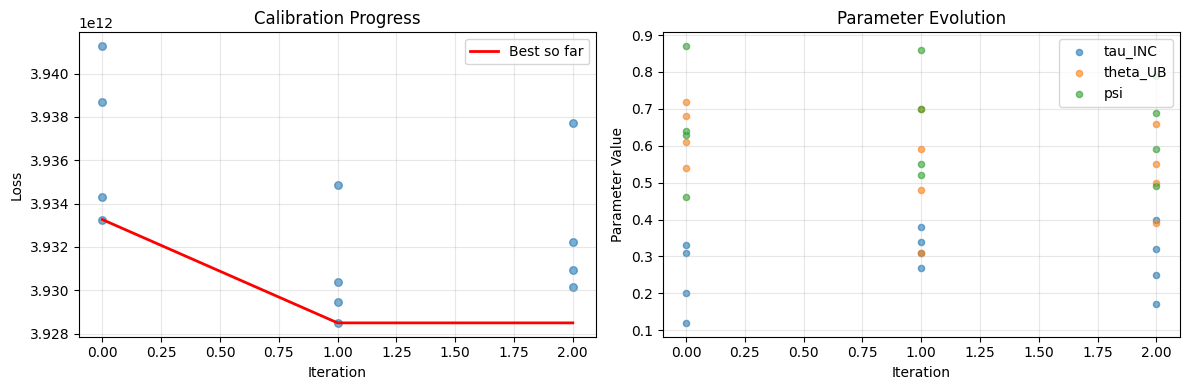

INFO:uk_abm.calibrate_beforeit:Plotting parameter space exploration
/Users/lukasalemu/Documents/00. Bank of England/03. MPIL/uk_abm/src/uk_abm/calibrate_beforeit.py:266: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


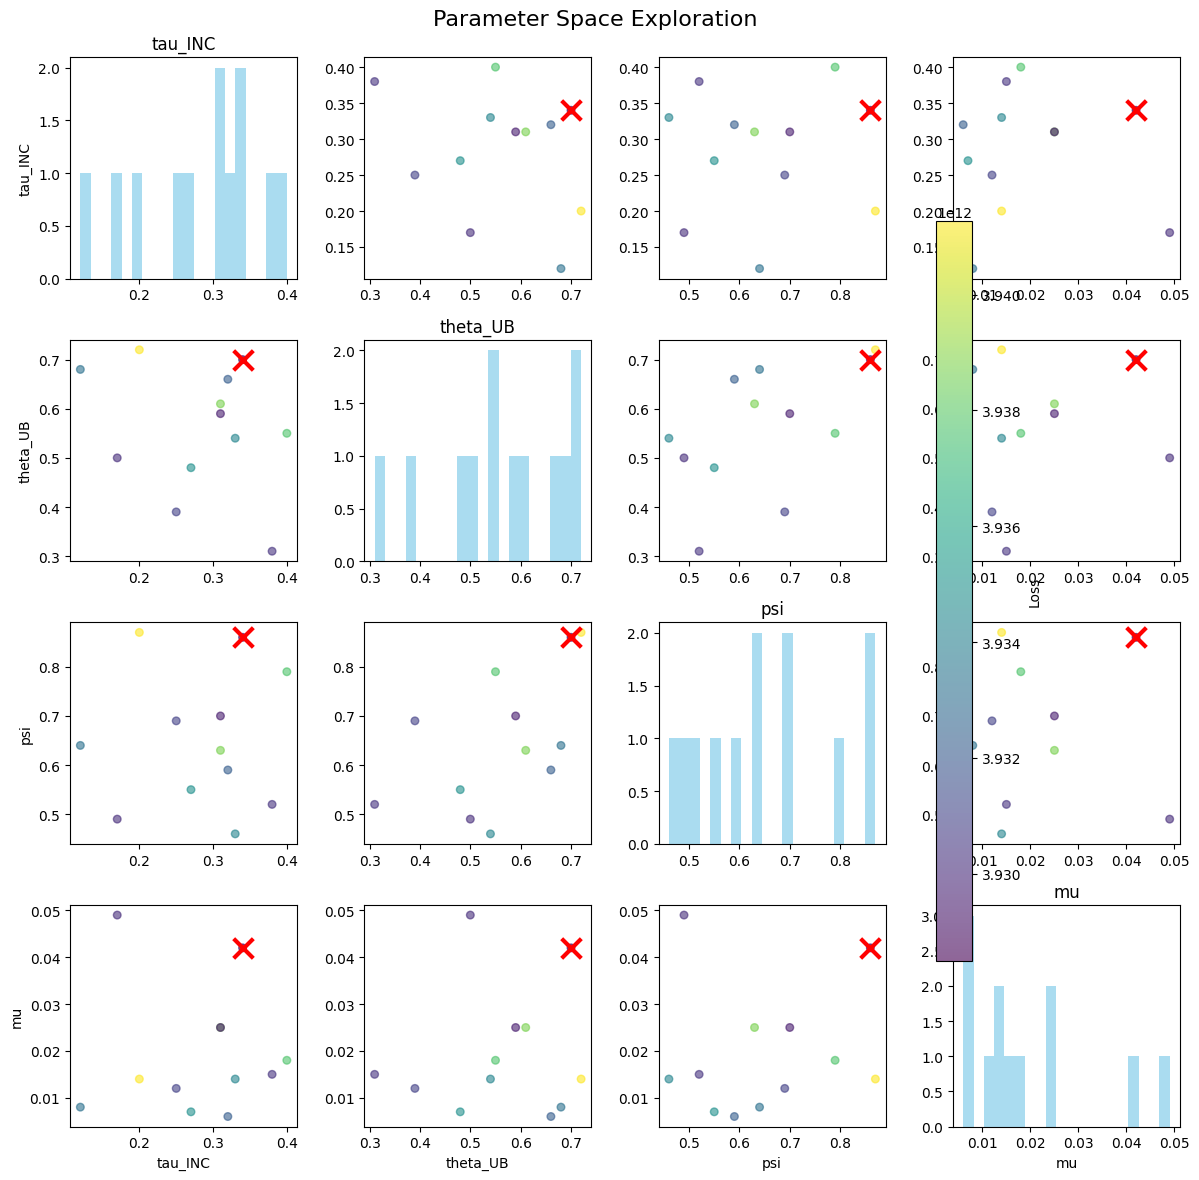

INFO:uk_abm.calibrate_beforeit:Comparing best simulation with target data
INFO:uk_abm.julia_model_wrapper:Running simulation with T=8, ensemble_size=8, seed=42
INFO:uk_abm.julia_model_wrapper:Simulation completed successfully
INFO:uk_abm.model_results:Created calibration array with shape (8, 25) for variables: ['compensation_employees', 'euribor', 'gdp_deflator_growth_ea', 'nominal_capitalformation', 'nominal_exports', 'nominal_fixed_capitalformation', 'nominal_fixed_capitalformation_dwellings', 'nominal_gdp', 'nominal_government_consumption', 'nominal_gva', 'nominal_household_consumption', 'nominal_imports', 'operating_surplus', 'real_capitalformation', 'real_exports', 'real_fixed_capitalformation', 'real_fixed_capitalformation_dwellings', 'real_gdp', 'real_gdp_ea', 'real_government_consumption', 'real_gva', 'real_household_consumption', 'real_imports', 'taxes_production', 'wages']


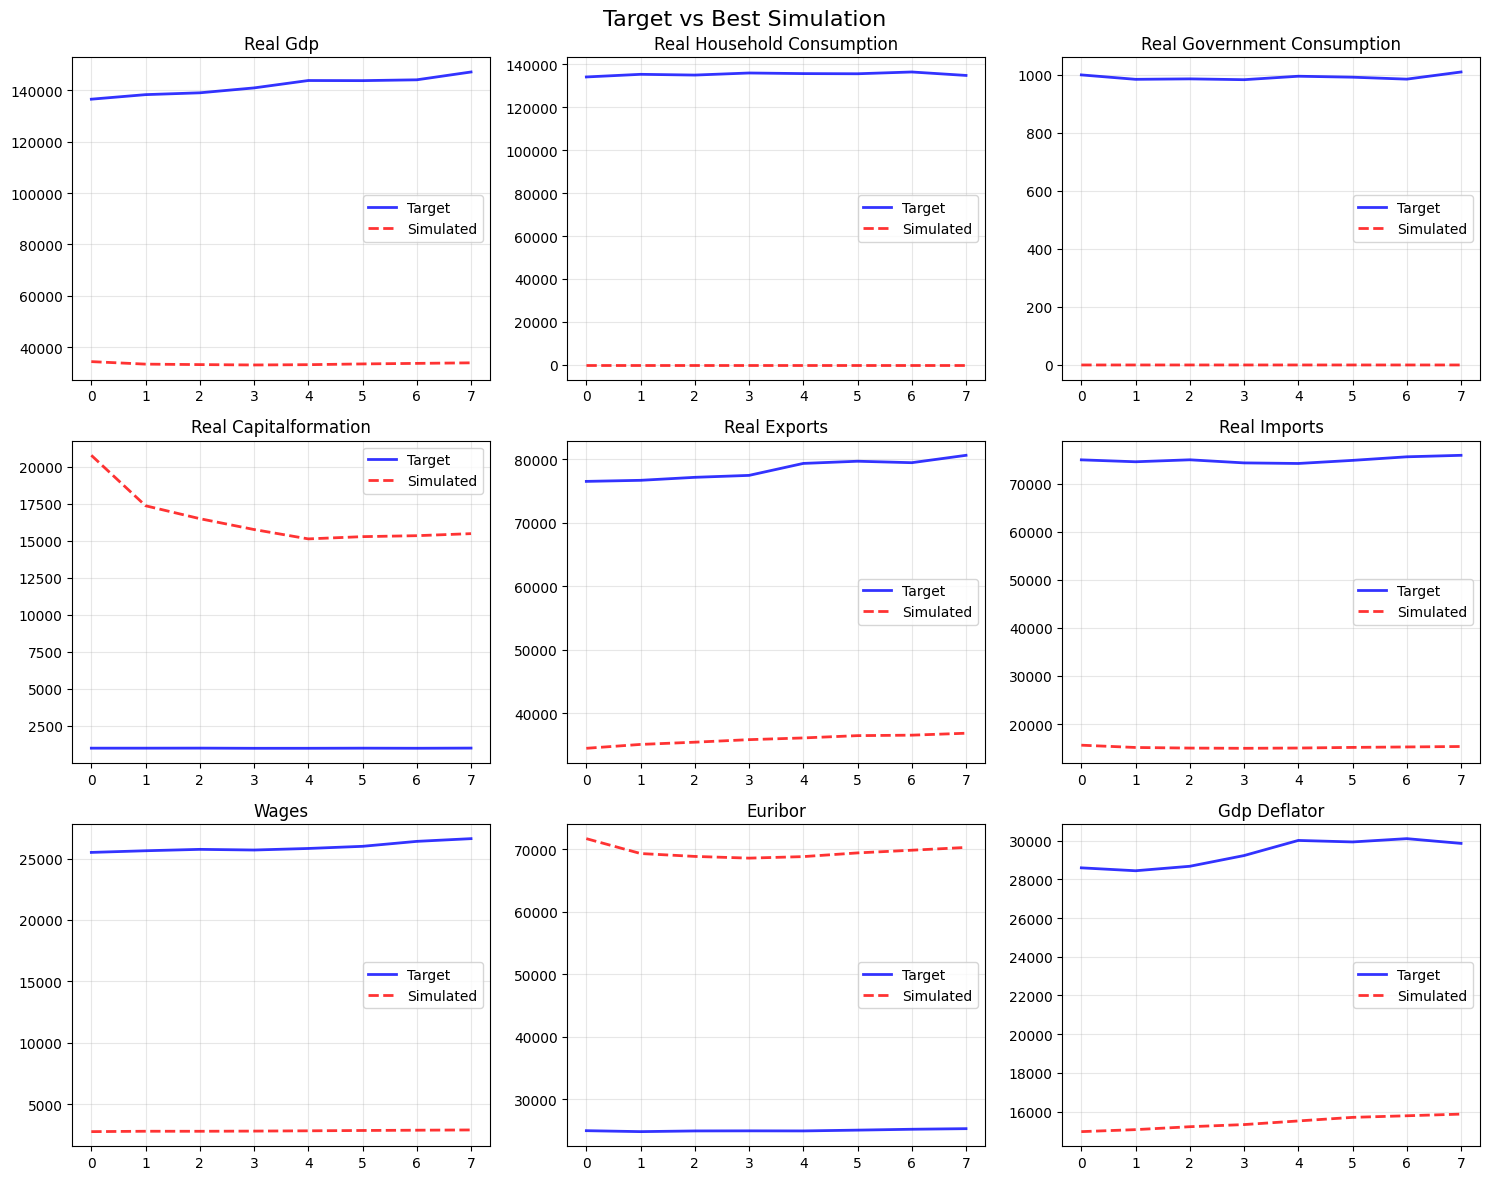

INFO:uk_abm.calibrate_beforeit:Saving detailed results


Analysis completed!
Check ../calibration_results/notebook_test_20250725_1731 for detailed results and plots


In [14]:
# Step 6: Analyze calibration results
print("Step 6: Analyzing calibration results...")

# Show the best parameters found
print(f"Best parameters found (loss: {best_losses[0]:.6f}):")
best_param_dict = {}
for name, value in zip(param_names, best_params[0]):
    best_param_dict[name] = value
    print(f"  {name:15s}: {value:8.4f}")

# Compare with original values
print("\nParameter changes from original values:")
for name in param_names[:10]:  # Show first 10
    original = current_values.get(name, 0.0)
    calibrated = best_param_dict[name]
    change_pct = ((calibrated - original) / original * 100) if original != 0 else 0
    print(f"  {name:15s}: {original:8.4f} → {calibrated:8.4f} ({change_pct:+6.1f}%)")

# Run analysis (this will save detailed results)
print("\nRunning detailed analysis...")
analyze_calibration_results(
    calibrator=calibrator,
    model_wrapper=wrapper,
    target_data=target_data,
    data_metadata=metadata,
    target_data_source="synthetic",
    base_parameters="AUSTRIA2010Q1",
    results_folder=results_folder,
)

print("Analysis completed!")
print(f"Check {results_folder} for detailed results and plots")
